# Stable Diffusion Overview

#### Important Packages

In [7]:
import logging, math, os
from pathlib import Path
from base64 import b64encode

import cv2 # Library for computer vision.
import numpy as np
import torch # Package with framework for Machine Learning with GPU acceleration based on numpy. Used for working with Tensors (generalisation of Matrix to n amount of dimensions).
import matplotlib.pyplot as plt # Graphs in python

from transformers import CLIPTextModel, CLIPTokenizer # Package with library of transformers implementations (state-of-the-art model for NLP). Used for tokenization of text and Autoencoder Model.
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler, StableDiffusionPipeline # Package with library of Stable Diffusion implementations (state-of-the-art model text2img generation). Heart of this Notebook.
from PIL import Image # Package for image manipulation. Used mainly to read image and put it to numpy format.
from IPython.display import HTML


from tqdm.auto import tqdm # Package for simple progress bars.

logging.disable(logging.WARNING)

device = "cuda"

#### Defining initial *PyTorch* settings

In [8]:
# pipe = StableDiffusionPipeline.from_pretrained("./stable-diffusion-v1-5/", torch_dtype=torch.float16) # Load the model from HD to RAM with lower precision.
pipe = StableDiffusionPipeline.from_pretrained("./stable-diffusion-2-base/", torch_dtype=torch.float16) # Load the model from HD to RAM with lower precision.
device = "cuda"
_ = pipe.to(device) # Load the model from RAM to VRAM (GPU)

## Simple Txt2Img Generation

100%|██████████| 50/50 [00:08<00:00,  6.23it/s]


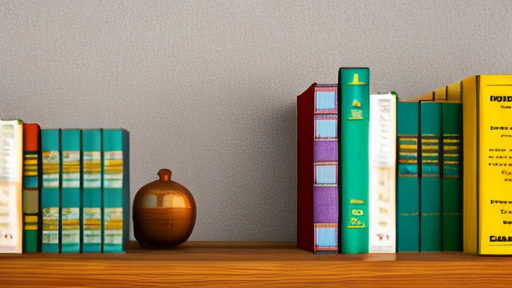

In [18]:
torch.manual_seed(1024)
img = pipe(
    prompt="single character, golem hero, realistic",
    negative_prompt="clay, game",
    )
img.images[0]
img.images[1]


## Txt2Img From Separate Models

In [19]:
VAE_img = Image.open("./Zrzut ekranu 2022-12-21 142935.png")

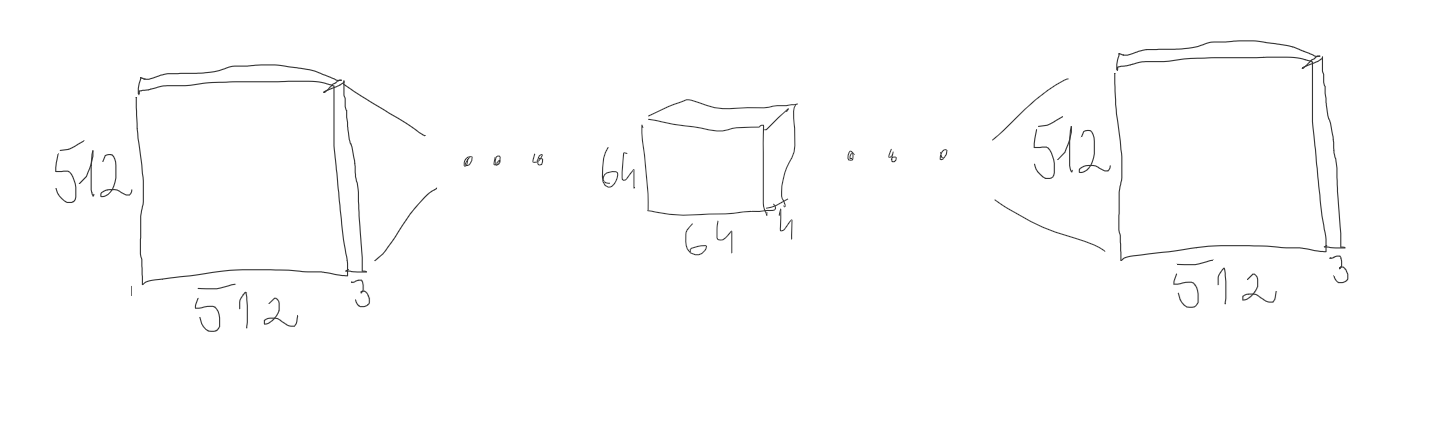

In [94]:
VAE_img

In [20]:
tokenizer = pipe.tokenizer # Cuts text into the pieces and encodes it to  some number.
text_encoder = pipe.text_encoder # Neural network which encodes numbers to latent space embeddings.
vae = pipe.vae # Neural Network (NN) for image compression and decompression.
unet = pipe.unet # NN which denoises the latent space with help of text embedding.
scheduler = pipe.scheduler # Manager of the photo creation process - not a NN.


#### Defining image generation parameters

In [21]:
prompt = ["a photograph of the golem riding a horse"]

height = 512
width = 512

num_inference_steps = 50

guidance_scale = 7.5
batch_size = 1

#### Tokenizing words to numbers

In [22]:
text_input = tokenizer("Golem Hero", padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids']

tensor([[49406,   650,  8428,  3756, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

In [23]:
print(tokenizer.decode(650))
print(tokenizer.decode(8428))

for text_token in text_input["input_ids"]:
    print(tokenizer.decode(text_token))


go
lem
<|startoftext|>golem hero <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [24]:
text_input['attention_mask']

tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])

#### Turning tokens to latent embeddings

In [25]:
text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0].half()
print(text_embeddings.shape)
print(text_embeddings[0][1])

torch.Size([1, 77, 1024])
tensor([ 0.0773, -0.0746, -0.5752,  ..., -0.6465,  0.3921,  0.3960],
       device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)


In [26]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0].half()
print(uncond_embeddings.shape)
print(uncond_embeddings[0][1])

torch.Size([1, 77, 1024])
tensor([ 1.4111,  0.0088, -0.4290,  ...,  1.0371, -0.6743,  1.5049],
       device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)


In [27]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [28]:
torch.manual_seed(100)
latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8))
latents = latents.to("cuda").half()
latents.shape

torch.Size([1, 4, 64, 64])

#### Setting number of steps of inference

In [29]:
scheduler.set_timesteps(num_inference_steps)

#### Defining helper functions to plot and decode latents

In [30]:
def plot_latents(latents, title: str = None):
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    for c in range(4):
        axs[c].imshow(latents[0][c].cpu(), cmap='Greys')

def plot_encoded(encoded, title: str = None, isPermuted: bool = True):
    fig, axs = plt.subplots(1, 3)
    if title:
        axs[0].set_title(title)
    for c in range(3):
        axs[c].imshow(encoded[c].cpu() if isPermuted else encoded[:][c][:] , cmap='Blues')

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def latents_callback(i, t, latents, latents_iterations = None, image_iterations = None):
    # print("i: " + str(i))
    image = latents_to_pil(latents)
    image[0].save(f"output/iteration_{i}.png")
    if image_iterations != None:
        # print("hello image_iterations")
        image_iterations.append(
            np.array(image[0])
        )
    latents = 1 / 0.18215 * latents
    if i % 5 == 0:
        # print(latents.shape)
        if latents_iterations != None:
            latents_iterations.append(latents)
        plot_latents(latents, f"iteration: #{i}: latents = 1 / 0.18215 * latents")

def imgs_to_video(imgs, video_name='video.mp4', fps=9):
    # Source: https://stackoverflow.com/questions/52414148/turn-pil-images-into-video-on-linux
    video_dims = (512, 512)
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')    
    video = cv2.VideoWriter(video_name, fourcc, fps, video_dims)
    for img in imgs:
        tmp_img = img.copy()
        video.write(cv2.cvtColor(np.array(tmp_img), cv2.COLOR_RGB2BGR))
    video.release()
    
def show_video(name):
    display(HTML(
        """<video width="512" height="512" controls><source src="./video.mp4" type="video/mp4"></video>"""
    ))

#### Performing Inference

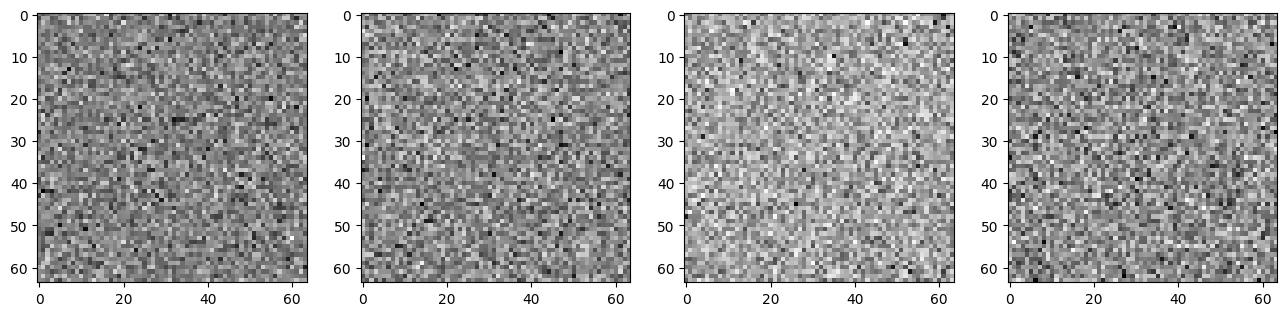

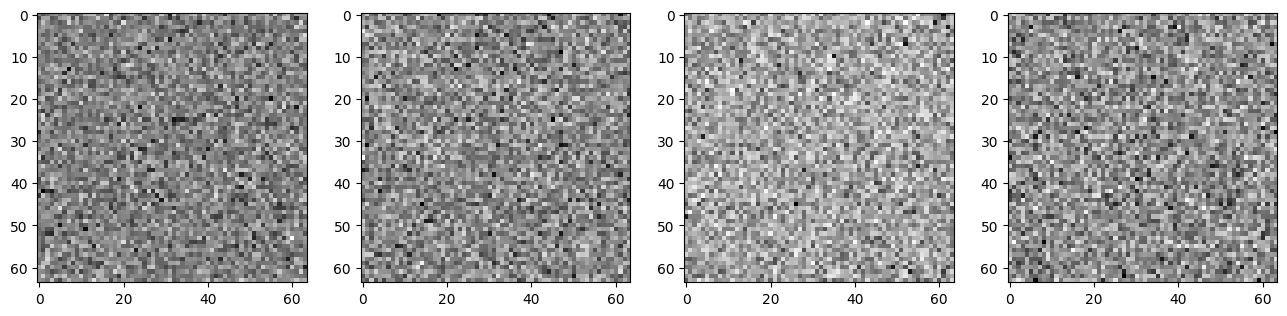

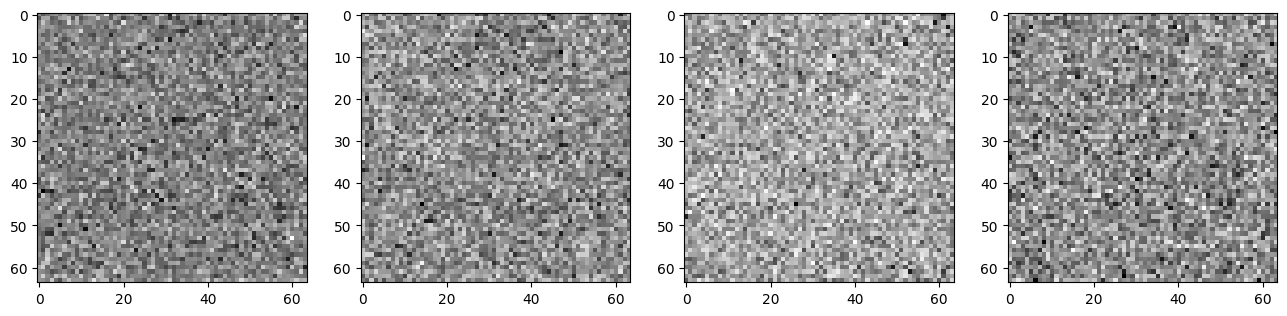

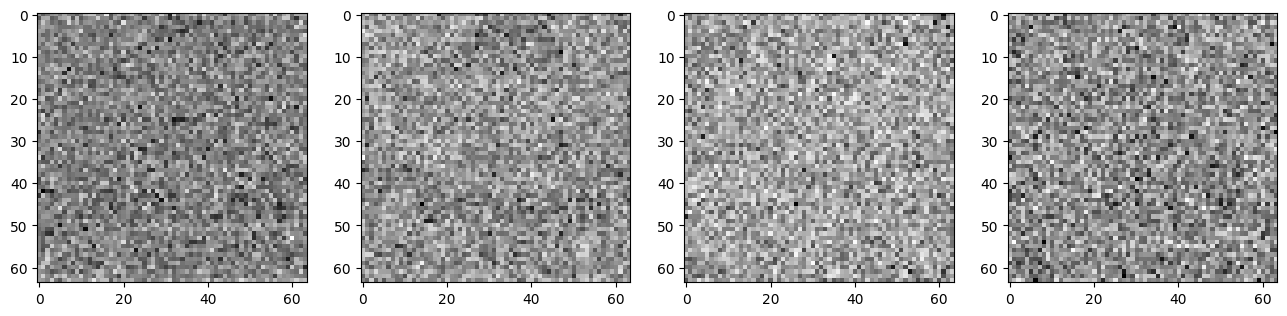

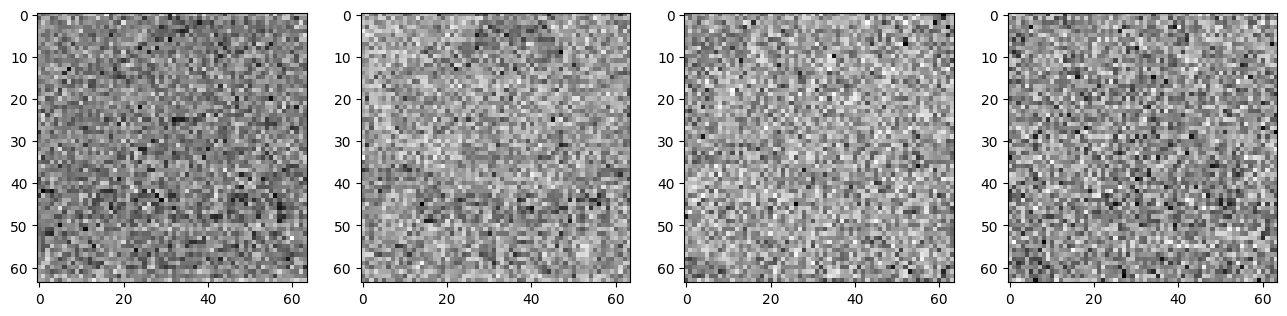

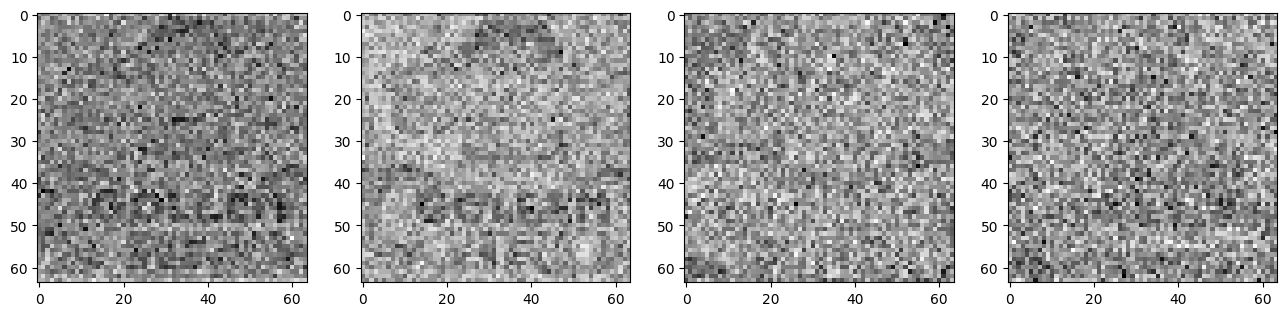

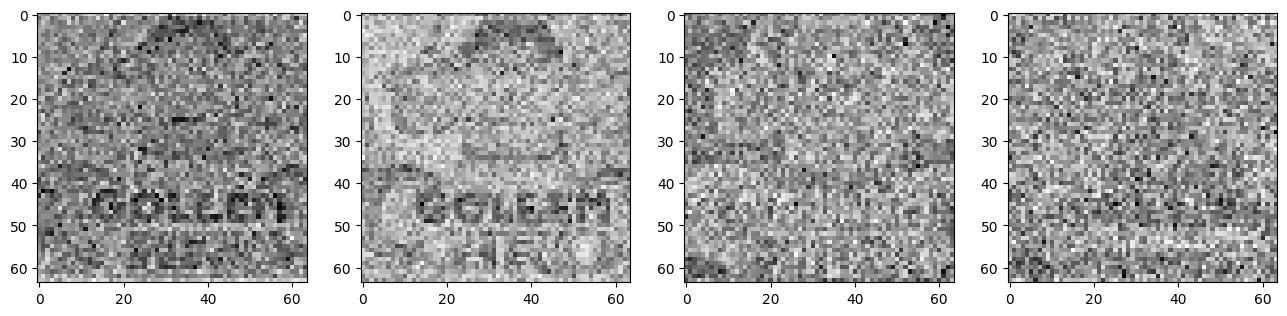

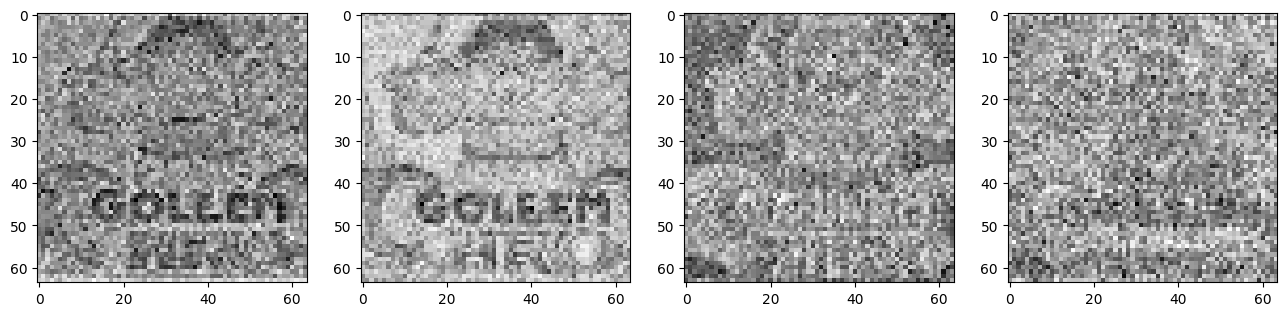

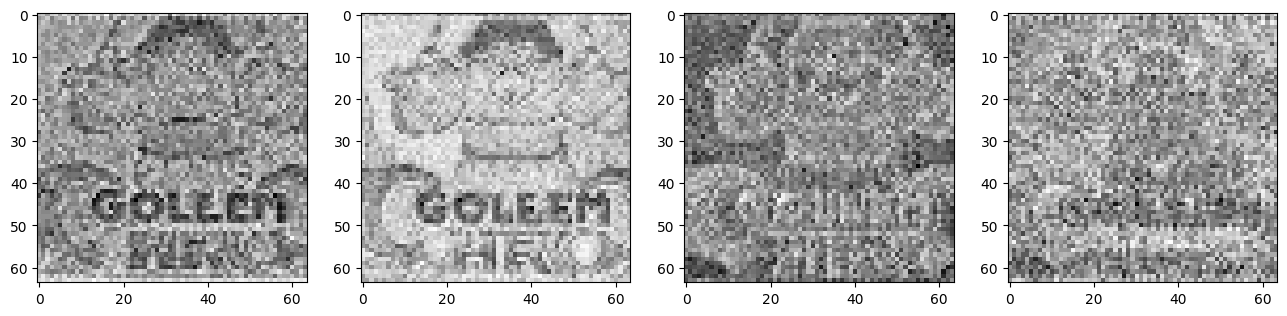

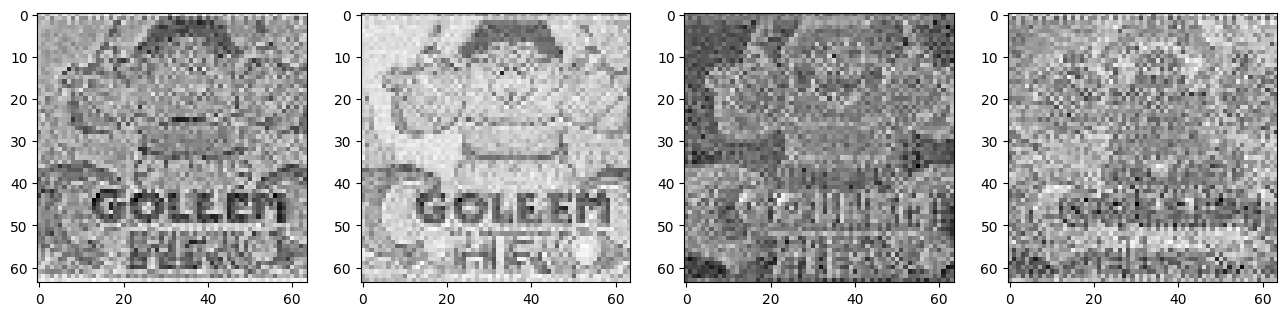

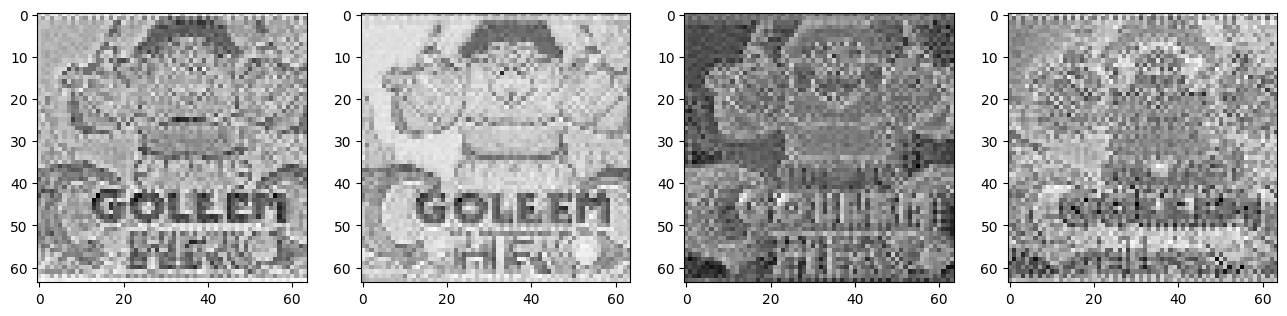

In [31]:
image_iterations = list()
latent_iterations = list() 

for i, t in enumerate(scheduler.timesteps):
    input = torch.cat([latents] * 2)
    input = scheduler.scale_model_input(input, t)

    # predict the noise residual
    with torch.no_grad(): pred = unet(input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    pred_uncond, pred_text = pred.chunk(2)
    pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

    # compute the "previous" noisy sample
    latents = scheduler.step(pred, t, latents).prev_sample
    latents_callback(i, t, latents.clone(), image_iterations=image_iterations)

#### Decoding and showing the result

In [32]:
with torch.no_grad(): image = vae.decode(1 / 0.18215 * latents).sample

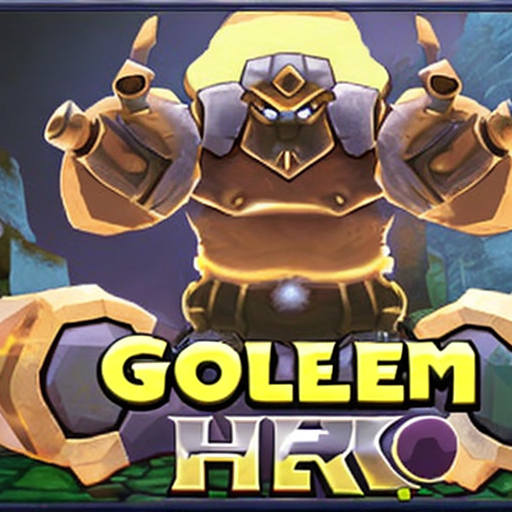

In [33]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

In [34]:
imgs_to_video(image_iterations)